# Libraries

In [ ]:
import math
import os
import torch
import torch.nn as nn
import torch.onnx
from io import open
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import random
import sys
import urllib.request
from urllib.parse import urlparse
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Hyperparameters

In [ ]:
batch_size = 20
sequence_len = 35
hidden_size = 200
layers = 2
epochs = 20
max_norm = 1


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('using device: ', torch.cuda.get_device_name(device))
else:
  device = torch.device('cpu')
  print('using cpu')

using device:  Tesla K80


# Data loading

In [ ]:

train_file = '/content/drive/Shareddrives/ex2_302377551_203092234/ptb.train.txt'
valid_file = '/content/drive/Shareddrives/ex2_302377551_203092234/ptb.valid.txt'
test_file = '/content/drive/Shareddrives/ex2_302377551_203092234/ptb.test.txt'

def data_load(sequence_len, batch_size, shuffle, device):

  f = open(train_file, 'r')
  f = f.read()
  train = f.split()

  g = open(valid_file, 'r')
  g = g.read()
  valid = g.split()

  h = open(test_file, 'r')
  h = h.read()
  test = h.split()

  words = sorted(set(train))
  vocabulary_size = len(words)
  words_indices = {w: i for i, w in enumerate(words)}

  data_lists = {'train': [words_indices[c] for c in train], 'validation': [words_indices[c] for c in valid], 'test': [words_indices[c] for c in test] }

  print('Vocabulary Size:',vocabulary_size)

  data_loaders = {}
  num_batches_save= []

  for data_type, data in data_lists.items():
    num_batches = len(data)//sequence_len
    num_batches -= num_batches % batch_size
    num_batches_save.append(num_batches)
    x = data[:num_batches*sequence_len]
    y = data[1:num_batches*sequence_len+1]
    xt = torch.tensor(x, dtype=torch.int64, device=device).reshape(num_batches, sequence_len)
    yt = torch.tensor(y, dtype=torch.int64, device=device).reshape(num_batches, sequence_len)
    data_loaders[data_type] = DataLoader(dataset=TensorDataset(xt, yt), batch_size=batch_size, shuffle=shuffle)

  return data_loaders, vocabulary_size ,num_batches_save
  
data_loaders, vocab_size ,num_batches = data_load(sequence_len, batch_size, shuffle=True, device=device)


print(len(data_loaders['train']))
print(len(data_loaders['validation']))
print(len(data_loaders['test']))
t=0
for x, y in data_loaders['validation']:
 t +=1
print(x.shape, y.shape)
print(t)
print(num_batches)

Vocabulary Size: 9999
1267
100
112
torch.Size([20, 35]) torch.Size([20, 35])
100
[25340, 2000, 2240]


# Class Network

In [ ]:

class RNN(nn.Module):

  def __init__(self, rnn_type, tokens, n_in, n_hid, n_layers, drop_prob):
    super(RNN, self).__init__()
    self.tokens = tokens
    self.drop_prob = nn.Dropout(drop_prob)
    self.encoder = nn.Embedding(tokens, n_in)
    if rnn_type in ['LSTM', 'GRU']:
      self.rnn = getattr(nn, rnn_type)(n_in, n_hid, n_layers, dropout=drop_prob)
    self.n_hid = n_hid
    self.n_layers = n_layers
    self.decoder = nn.Linear(n_hid, tokens)
    self.init_weights()
    self.rnn_type = rnn_type
    

  def init_weights(self):
    nn.init.uniform_(self.encoder.weight, -0.1, 0.1)
    nn.init.zeros_(self.decoder.weight)
    nn.init.uniform_(self.decoder.weight, -0.1, 0.1)

  def forward(self, input, hidden):
    embedded = self.drop_prob(self.encoder(input))
    output, hidden = self.rnn(embedded, hidden)
    output = self.drop_prob(output)
    decoded = self.decoder(output)
    decoded = decoded.view(-1, self.tokens)
    return F.log_softmax(decoded, dim=1), hidden

  def init_hidden(self, batch_size):
    weight = next(self.parameters())
    if self.rnn_type == 'GRU':
      return weight.new_zeros(self.n_layers, batch_size, self.n_hid)
    else:
      return (weight.new_zeros(self.n_layers, batch_size, self.n_hid), weight.new_zeros(self.n_layers, batch_size, self.n_hid))










In [ ]:
def repackage_hidden(h):

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

# Evaluation

In [ ]:
def evaluation(model, name):
  model.eval()

  if name =='train':
    nb = num_batches[0]
  if name =='validation':
    nb = num_batches[1]
  if name =='test':
    nb = num_batches[2]

  hidden = model.init_hidden(batch_size)
  loss = 0
  perplexity = 0

  with torch.no_grad():
    for x, y in data_loaders[name]:    
      output, hidden = model(x.t(), hidden)
      loss += F.nll_loss(output, y.t().contiguous().view(-1))
      perplexity += torch.exp(loss).item() / y.shape[0]
      hidden = repackage_hidden(hidden)

  loss = loss / (nb//batch_size)
  perplexity = math.exp(loss)

  print('-' * 89)
  print(name + ' loss {:5.2f} | {} ppl {:8.2f}'.format(loss, name, math.exp(loss)))
  print('-' * 89)
  
  return loss, perplexity




# Train

In [ ]:
def train(model):
  model.train()

  train_losses, val_losses = [], []
  train_prep, val_prep = [], []
  loss_tot = 0
  for e in range(epochs):
    model.train()
    hidden = model.init_hidden(batch_size)
    loss_t = 0
    loss_v = 0
    counter = 0
    
    for x, y in data_loaders['train']:
      model.zero_grad()
      hidden = repackage_hidden(hidden)
      output, hidden = model(x.t(), hidden)
      model.zero_grad()
      loss_t = criterion(output, y.t().contiguous().view(-1))
      loss_tot += loss_t.item()
      loss_t.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
      optimizer.step()
      if counter % 500 == 0:
       print("Epoch: {}/{}...".format(e+1, epochs),
                    "Step: {}...".format(counter),
                    "Train Loss: {:.4f}...".format(loss_t.item()),
                    "Train Preplexity: {:.4f}...".format(np.exp(loss_t.item())))    
      counter = counter+1
    loss_tot = loss_tot / counter

    loss_v, preplexity_v = evaluation(model, 'validation')
    train_losses.append(loss_tot)
    train_prep.append(np.exp(loss_tot))  
    val_losses.append(loss_v)
    val_prep.append(np.exp(loss_v.item()))
    model.train()
  plt.plot(train_prep, label='Training preplexity')
  plt.plot(val_prep, label='Validation preplexity')
  plt.legend(['Training preplexity', 'Validation preplexity'])
  plt.savefig('graph.png')
  plt.show()






# LSTM

Epoch: 1/20... Step: 0... Train Loss: 9.2168... Train Preplexity: 10064.3132...
Epoch: 1/20... Step: 500... Train Loss: 6.5190... Train Preplexity: 677.9173...
Epoch: 1/20... Step: 1000... Train Loss: 6.2960... Train Preplexity: 542.3734...
-----------------------------------------------------------------------------------------
validation loss  5.90 | validation ppl   364.51
-----------------------------------------------------------------------------------------
Epoch: 2/20... Step: 0... Train Loss: 5.9926... Train Preplexity: 400.4472...
Epoch: 2/20... Step: 500... Train Loss: 5.6420... Train Preplexity: 282.0236...
Epoch: 2/20... Step: 1000... Train Loss: 5.6869... Train Preplexity: 294.9861...
-----------------------------------------------------------------------------------------
validation loss  5.52 | validation ppl   250.78
-----------------------------------------------------------------------------------------
Epoch: 3/20... Step: 0... Train Loss: 5.4529... Train Preplexity

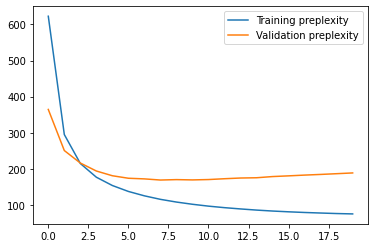

In [ ]:
model = RNN('LSTM', vocab_size, sequence_len, hidden_size, layers, 0)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=10)
criterion = nn.NLLLoss()
train(model)
torch.save(model.state_dict(), '/content/drive/Shareddrives/ex2_302377551_203092234/LSTM.pt')

# LSTM + DROPOUT

In [ ]:
model = RNN('LSTM', vocab_size, sequence_len, hidden_size, layers, 0.3)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=10)
criterion = nn.NLLLoss()
train(model)
torch.save(model.state_dict(), '/content/drive/Shareddrives/ex2_302377551_203092234/LSTM_dropout.pt')

# GRU

In [ ]:
model = RNN('GRU', vocab_size, sequence_len, hidden_size, layers, 0)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
train(model)
torch.save(model.state_dict(), '/content/drive/Shareddrives/ex2_302377551_203092234/GRU.pt')

# GRU + Dropout

Epoch: 1/15... Step: 0... Train Loss: 9.2157... Train Preplexity: 10053.2719...
Epoch: 1/15... Step: 500... Train Loss: 6.6757... Train Preplexity: 792.8782...
Epoch: 1/15... Step: 1000... Train Loss: 6.1430... Train Preplexity: 465.4492...
-----------------------------------------------------------------------------------------
validation loss  5.91 | validation ppl   369.21
-----------------------------------------------------------------------------------------
Epoch: 2/15... Step: 0... Train Loss: 6.3147... Train Preplexity: 552.6271...
Epoch: 2/15... Step: 500... Train Loss: 5.5664... Train Preplexity: 261.4922...
Epoch: 2/15... Step: 1000... Train Loss: 5.6784... Train Preplexity: 292.4677...
-----------------------------------------------------------------------------------------
validation loss  5.55 | validation ppl   258.13
-----------------------------------------------------------------------------------------
Epoch: 3/15... Step: 0... Train Loss: 6.0042... Train Preplexity

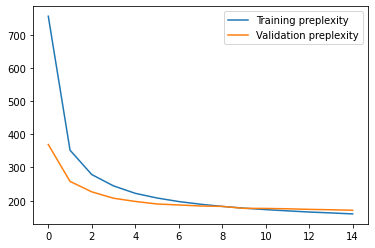

In [ ]:
model = RNN('GRU', vocab_size, sequence_len, hidden_size, layers, 0.3)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
criterion = nn.NLLLoss()
train(model)
torch.save(model.state_dict(), '/content/drive/Shareddrives/ex2_302377551_203092234/GRU_dropout.pt')